<a href="https://colab.research.google.com/github/SinghAnkit1010/Image-Segmentation-using-UNet/blob/main/UNet_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! ! pip install -q kaggle

In [2]:
from google.colab import files
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D,Conv2DTranspose,MaxPool2D,Dropout,Input,Activation,concatenate
import os
from skimage import io
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
files.upload()

In [4]:
!mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c data-science-bowl-2018

In [ ]:
!unzip /content/data-science-bowl-2018.zip

In [9]:
!mkdir train

In [10]:
!mkdir test

In [ ]:
!unzip /content/stage1_train.zip -d /content/train

In [ ]:
!unzip /content/stage1_test.zip -d /content/test

In [13]:
class UNet:
  def __init__(self,n_classes):
    self.classes = n_classes
  def convolution_block(self,inputs,n_filters):
    x = inputs
    for i in range(2):
      x = Conv2D(filters = n_filters,kernel_size = (3,3),kernel_initializer="he_normal",padding = 'same')(x)
      x = Activation('relu')(x)
    return x

  def encoder_block(self,inputs,n_filters,pool_size):
    f = self.convolution_block(inputs,n_filters)
    p = MaxPool2D(pool_size=pool_size,strides = (2,2))(f)
    p = Dropout(0.3)(p)
    return f,p


  def encoder(self,inputs):
    f1,p = self.encoder_block(inputs,n_filters = 64,pool_size = (2,2))
    f2,p = self.encoder_block(p,n_filters = 128,pool_size = (2,2))
    f3,p = self.encoder_block(p,n_filters = 256,pool_size = (2,2))
    f4,p = self.encoder_block(p,n_filters = 512,pool_size = (2,2))
    return p,(f1,f2,f3,f4)


  def bottleneck(self,inputs):
    return self.convolution_block(inputs,n_filters=1024)

  def decoder_block(self,inputs,encoder_output,n_filters):
    u = Conv2DTranspose(filters = n_filters,kernel_size = (3,3),strides = (2,2),padding = "same")(inputs)
    c = concatenate([u,encoder_output])
    c = Dropout(0.3)(c)
    outputs = self.convolution_block(c,n_filters)
    return outputs

  def decoder(self,inputs,convs,n_classes):
    f1,f2,f3,f4 = convs
    c6 = self.decoder_block(inputs,f4,n_filters = 512)
    c7 = self.decoder_block(c6,f3,n_filters = 256)
    c8 = self.decoder_block(c7,f2,n_filters = 128)
    c9 = self.decoder_block(c8,f1,n_filters = 64)
    outputs = Conv2D(filters = n_classes,kernel_size = (3,3),strides = (1,1),activation = 'sigmoid',padding = 'same')(c9)
    return outputs

  def make_network(self):
    inputs = Input(shape = (128,128,3,))
    p,convs = self.encoder(inputs)
    encoder_output = self.bottleneck(p)
    outputs = self.decoder(encoder_output,convs,self.classes)
    model = tf.keras.Model(inputs = inputs,outputs = outputs)
    return model

In [14]:
model = UNet(1)
model = model.make_network()

In [15]:
#model.build((128,128,3))

In [16]:
model.compile(optimizer = "adam",loss = "binary_crossentropy",metrics = ["accuracy","Precision"])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
#tf.keras.utils.plot_model(model,'model.png',rankdir = "H")

In [19]:
train_path = '/content/train/'

In [20]:
x_train = []
y_train = []
for folders in os.listdir(train_path):
  img = io.imread(train_path + folders + '/images/' + folders + '.png')[:,:,:3]
  img = img/255.0
  x_train.append(resize(img,(128,128)))
  mask_ = np.zeros((128,128,1),dtype = np.bool)
  for masks in (os.listdir(os.path.join(train_path,folders,'masks'))):
    mask = io.imread(train_path + folders + '/masks/' + masks)
    mask = resize(mask,(128,128))
    mask = np.expand_dims(mask,axis=-1)
    mask_ = np.maximum(mask_,mask)
  y_train.append(mask_)
x_train = np.array(x_train)
y_train = np.array(y_train)

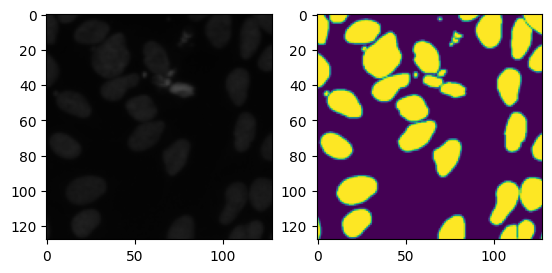

In [40]:
plt.subplot(1,2,1)
plt.imshow(x_train[0])
plt.subplot(1,2,2)
plt.imshow(y_train[0])
plt.show()

In [22]:
test_path = '/content/test/'

In [23]:
x_test = []
for folders in os.listdir(test_path):
  img = io.imread(test_path + folders + '/images/' + folders + '.png')[:,:,:3]
  img = img/255.0
  x_test.append(np.expand_dims(resize(img,(128,128)),axis = 0))
x_test = np.array(x_test)

In [24]:
x_test.shape

(65, 1, 128, 128, 3)

In [25]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5',monitor = 'val_loss',save_best_only = True,save_weights_only = True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)

In [ ]:
model.fit(x_train,y_train,batch_size = 32,epochs = 50,callbacks = [checkpoint,early_stopping],validation_split = 0.2)

In [27]:
y_pred = model.predict(x_test[0])

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 81ms/step


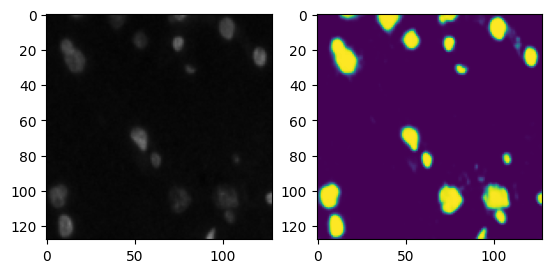

1/1 [==============================] - 0s 33ms/step


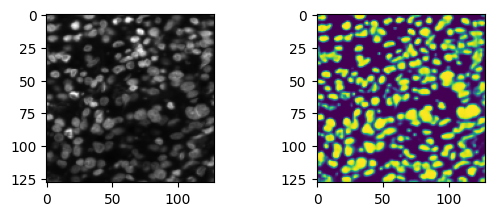

1/1 [==============================] - 0s 31ms/step


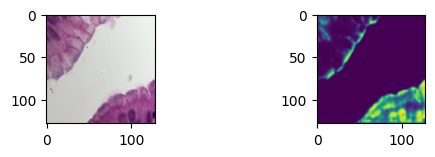

1/1 [==============================] - 0s 20ms/step


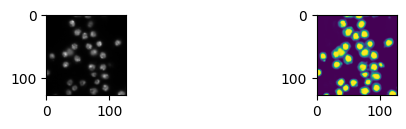

In [39]:
for i in range(1,5):
  plt.subplot(i,2,1)
  plt.imshow(x_test[i][0])
  plt.subplot(i,2,2)
  plt.imshow(model.predict(x_test[i])[0])
  plt.show()